# 贝叶斯推断 简介

为了了解并尝试使用贝叶斯方法，本文简单记录PyMC3的基本情况。

本文主要参考以下资料，以了解 PyMC3 究竟能够用来干什么。

- [Probabilistic Programming and Bayesian Methods for Hackers -- Chapter 1](https://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_PyMC3.ipynb)

在进入 PyMC3 之前，需要先了解一些贝叶斯推断 Bayesian inference 相关的基本概念。

首先，我们需要以贝叶斯的世界观来看待问题，这点可以参考这里：[贝叶斯学派与频率学派有何不同？](https://www.zhihu.com/question/20587681)。

贝叶斯解释概率为 对一个事件相信程度的衡量，也就是说对一件事情发生我们有多大的信念，而这其实是对概率的一种很自然的解释。频率学派从事件长期发生频率中来得到概率，但是很多时候我们并没有长期的记录，很多不确定事件只有很少几次记录。为了处理这种情况，贝叶斯学派将概率解释为 对一个事件发生的信念的衡量 measure of belief/confidence of an event occurring。简单地说，概率就是观点的总结，对一个事发生完全没信心，那么对信念的衡量就是0，充满信心，认为铁定发生，那么对信念的衡量就是1，零一之间就是对不同的结果发生都有一些信心。这和频率学派的概率也是一致的，比如观察到一个事件的频率，那么在没有其他外部信息的条件下，个人的信念就应该等于这个频率。那么根据概率等于信念的定义，对小样本事件，概率也可以很有意义，我们对一件事的信心有多大。

这里值得注意的是，信心被赋予了“我们”自己，而不是“自然”。所以对同一件事，由于背景信息的不同，不同的人会有不同的看法，比如一位内科病人表现出症状 X， y 和 z。有多种疾病可能导致所有这些症状，但仅存在一种疾病是真正导致病人生病的原因。一个医生会认为是一种疾病导致，但是第二位医生的信念可能就会略有不同。

贝叶斯就是这样将信念视为概率的哲学。当我们与世界互动时，我们会不断采用它，虽然只看到部分事实，但我们会收集证据以形成信念。为了与传统的概率表示法保持一致，我们把对一个事件A的信念表示为 P（A）。我们称这个量为先验概率。当看到更多证据后我们会更新信念。即使是证据与最初认为的相反，也不能忽略该证据。我们将更新后的信念表示为P（A|X），解释为给定证据 X后对事件A的信念。并称更新后的信念为后验概率，以便将其与先验概率进行对比。比如，P（A ）：病人可能患有多种疾病。 P（A|X）： 进行血液检查产生证据 X，从而考虑排除一些可能的疾病。

我们在看到新证据后没有完全放弃先前的信念 X，但是重新加权了先前的对不同事件信念的加权，以纳入新的证据（即，相比于与其他信念，我们对某些信念给予了更大的权重或信心）。通过引入事件的先验不确定性，我们已经承认我们所做的任何猜测都可能是非常错误的。观察数据，证据或其他信息后，我们更新信念，那么我们的猜测也就会更少有错。

简单总结，我们可以说贝叶斯推断就是根据看到的结果更新自己的信念。

那么实际应用中，贝叶斯推断是什么样的？

如果频率学派和贝叶斯学派推断都是编程函数，输入是概率问题，那么它们输出返回给用户的是不同的东西。频率推断函数会返回一个值，表示一个估计，而贝叶斯函数会返回 一组概率 probabilities。

比如，我们的输入，即统计问题为：“My code passed all X tests; is my code bug-free?”，那么频率推断函数会返回YES；而对贝叶斯函数，输入统计问题为：“Often my code has bugs. My code passed all X tests; is my code bug-free?”，返回的会是：“YES, with probability 0.8; NO, with probability 0.2”。注意输入的时候多了一点信息--“Often my code has bugs”，这个信息就是先验参数。有了它，就告诉贝叶斯函数我们的信念。

随着我们获取越来越多的证据实例，我们的先验信念会被新的证据淘汰。例如，先前的信念是荒谬的--“我觉得太阳今天爆炸”，而每天都会被证明这是错误的，那么我们希望贝叶斯推断能纠正这想法，或者至少使信念更好。表示 N 为我们拥有的证据的数量。当我们收集到无数证据时，即 N → ∞，我们的贝叶斯结果（通常）与频率派结果一致。因此，对于大N，统计推断可以是客观的。但对于小N，推论则更加不稳定：频率派估计会有更大的方差和更大的置信区间，而这时候正是贝叶斯分析的擅长。通过引入先验概率和返回概率（而不是一个标量值的估计），我们保留了反映小N数据集的统计推断不稳定性的不确定性。

先验后验关系，用的是贝叶斯公式；

$\begin{align}
 P( A | X ) = & \frac{ P(X | A) P(A) } {P(X) } \\\\[5pt]
& \propto P(X | A) P(A)\;\; (\propto \text{is proportional to })
\end{align}$

下面看例子。

掷硬币的示例总是会被拿来用，这里也不例外。先假设我们不确定硬币翻转时出现正面的可能性（虽然我们知道它是50％）。我们相信存在一定的真实潜在比率，称之为p，但对什么 p 是多少我们没有先验。

我们开始掷硬币，并记录观察结果： H 或者 T。一个有趣的问题是：随着我们观察到越来越多的数据，我们的推理将如何变化？更具体地说，当我们只有很少的数据时，与我们有很多数据时，我们的后验概率是什么样的。

下面，随着我们观察到数据量的增加（硬币翻转），我们绘制了一系列后验概率更新。

<ipython-input-1-36e33eca92c0>:18: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  sx = plt.subplot(len(n_trials)/2, 2, k+1)
<ipython-input-1-36e33eca92c0>:18: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  sx = plt.subplot(len(n_trials)/2, 2, k+1)
<ipython-input-1-36e33eca92c0>:18: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  sx = plt.subplot(len(n_trials)/2, 2, k+1)
<ipython-input-1-36e33eca92c0>:18: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  sx = plt.subplot(len(n_trials)/2, 2, k+1)
<ipython-input-1-36e33eca92c0>:18: Matpl

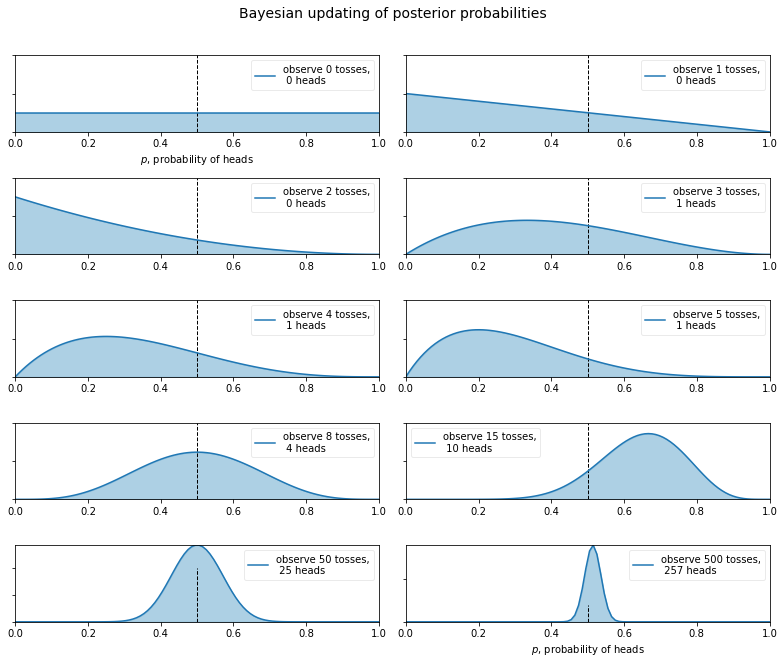

In [1]:
# The code below can be passed over, as it is currently not important, plus it
# uses advanced topics we have not covered yet. LOOK AT PICTURE, MICHAEL!
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
figsize(11, 9)

import scipy.stats as stats

dist = stats.beta
n_trials = [0, 1, 2, 3, 4, 5, 8, 15, 50, 500]
data = stats.bernoulli.rvs(0.5, size=n_trials[-1])
x = np.linspace(0, 1, 100)

# For the already prepared, I'm using Binomial's conj. prior.
for k, N in enumerate(n_trials):
    sx = plt.subplot(len(n_trials)/2, 2, k+1)
    plt.xlabel("$p$, probability of heads") \
        if k in [0, len(n_trials)-1] else None
    plt.setp(sx.get_yticklabels(), visible=False)
    heads = data[:N].sum()
    y = dist.pdf(x, 1 + heads, 1 + N - heads)
    plt.plot(x, y, label="observe %d tosses,\n %d heads" % (N, heads))
    plt.fill_between(x, 0, y, color="#348ABD", alpha=0.4)
    plt.vlines(0.5, 0, 4, color="k", linestyles="--", lw=1)

    leg = plt.legend()
    leg.get_frame().set_alpha(0.4)
    plt.autoscale(tight=True)


plt.suptitle("Bayesian updating of posterior probabilities",
             y=1.02,
             fontsize=14)

plt.tight_layout()

后验概率由曲线表示，不确定性与曲线的宽度成正比。如上图所示，当我们开始观察数据时，后验概率开始变化。最终，随着我们观察到越来越多的数据（硬币翻转），概率将越来越接近真实值p = 0.5 （以虚线标记）。

请注意，这些图并不总是在0.5处达到峰值。如果我们观察到非常极端的数据，例如说8次翻转而只有1个观察到正面，那么我们的分布看起来会偏离0.5左右的集结。随着越来越多的数据积累，我们将看到越来越多的概率被分配给p = 0.5。

下面引入PyMC，从一个概率分布 泊松分布开始。离散的， $Z \sim \text{Poi}(\lambda)$：

$P(Z = k) =\frac{ \lambda^k e^{-\lambda} }{k!}, \; \; k=0,1,2, \dots$

泊松分布一个特别的性质是 $E\large[ \;Z\; | \; \lambda \;\large] = \lambda$

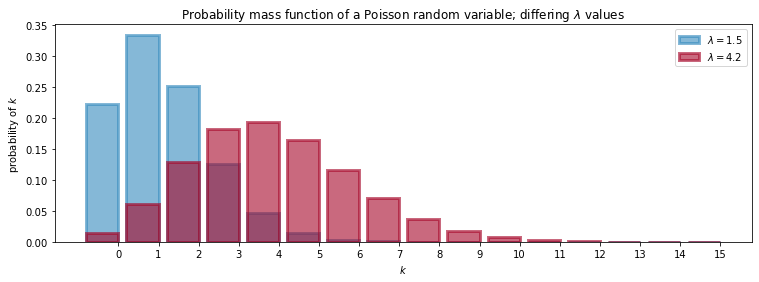

In [2]:
figsize(12.5, 4)

import scipy.stats as stats
a = np.arange(16)
poi = stats.poisson
lambda_ = [1.5, 4.25]
colours = ["#348ABD", "#A60628"]

plt.bar(a, poi.pmf(a, lambda_[0]), color=colours[0],
        label="$\lambda = %.1f$" % lambda_[0], alpha=0.60,
        edgecolor=colours[0], lw="3")

plt.bar(a, poi.pmf(a, lambda_[1]), color=colours[1],
        label="$\lambda = %.1f$" % lambda_[1], alpha=0.60,
        edgecolor=colours[1], lw="3")

plt.xticks(a + 0.4, a)
plt.legend()
plt.ylabel("probability of $k$")
plt.xlabel("$k$")
plt.title("Probability mass function of a Poisson random variable; differing \
$\lambda$ values");

还有一个连续形式的指数分布概率密度函数 $Z \sim \text{Exp}(\lambda)$：

$f_Z(z | \lambda) = \lambda e^{-\lambda z }, \;\; z\ge 0$

它也有一个性质：

$E[\; Z \;|\; \lambda \;] = \frac{1}{\lambda}$

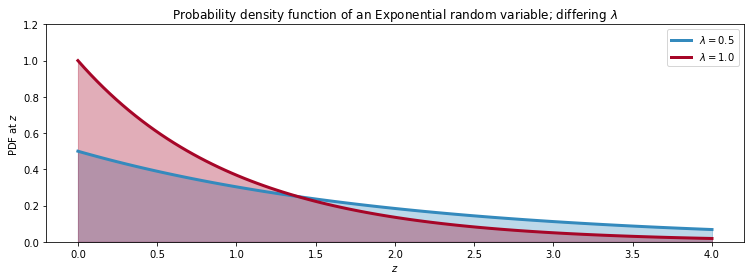

In [3]:
a = np.linspace(0, 4, 100)
expo = stats.expon
lambda_ = [0.5, 1]

for l, c in zip(lambda_, colours):
    plt.plot(a, expo.pdf(a, scale=1./l), lw=3,
             color=c, label="$\lambda = %.1f$" % l)
    plt.fill_between(a, expo.pdf(a, scale=1./l), color=c, alpha=.33)

plt.legend()
plt.ylabel("PDF at $z$")
plt.xlabel("$z$")
plt.ylim(0,1.2)
plt.title("Probability density function of an Exponential random variable;\
 differing $\lambda$");

$\lambda \;$就是现实中我们不知道的，要求的，需要根据统计得到的。我们只能观测Z，根据观测来判断$\lambda \;$。

看回贝叶斯推断，它关心的就是 $\lambda \;$ 是多少对应的信念，而不是$\lambda \;$具体是哪一个值。也就是我们给$\lambda \;$一个概率分布。

看例子--用户发送和接收文本消息的速率：

系统的用户会为您提供一系列的日常短信计数。随时间绘制的数据显示如下。很想知道用户的文字信息习惯是随着时间的变化而逐渐改变还是突然改变。如何对此建模？

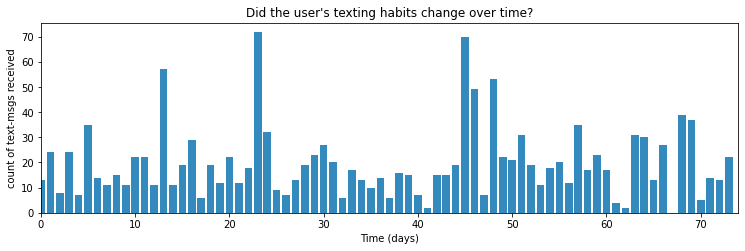

In [4]:
figsize(12.5, 3.5)
count_data = np.loadtxt("data/txtdata.csv")
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data);

我们用泊松分布来建模。表示第i天短信计数为$C_i$，

$C_i \sim \text{Poisson}(\lambda)$

我们不确定 λ参数值。从上面的图表可以看出，在观察期的后期，该比率可能会升高，这相当于说λ在观察过程中的某个时候增加。（更大的λ意味着给更大值分配更多的可能性。也就是说，在给定的一天发送许多文本消息的可能性更高。）

我们如何用数学表示这种观察？假设在观察期间的某天（称它为τ），参数 λ突然跳到更高的值。所以我们有两个λ 参数：τ前一个 ，剩余时间使用另一个。在文献中，像这样的突然转变会被称为switchpoint：

$\lambda = 
\begin{cases}
\lambda_1  & \text{if } t \lt \tau \cr
\lambda_2 & \text{if } t \ge \tau
\end{cases}$

如果实际上没有发生突然变化，确实 λ1=λ2，然后 λ后验分布应该看起来大致相等。

我们有兴趣推断未知的 λs。要使用贝叶斯推断，我们需要将先验概率分配给λ的不同可能值。什么是良好的λ1和 λ2的先验概率分布？λ可以是任何正数。如前所述，指数分布为正数提供了连续的密度函数，因此它可能是建模λ的好选择。但是请记住，指数分布采用自己的参数，因此我们需要在模型中包括该参数。我们称该参数为α。

$\begin{align}
&\lambda_1 \sim \text{Exp}( \alpha ) \\\
&\lambda_2 \sim \text{Exp}( \alpha )
\end{align}$

α被称为超参数或父变量。从字面上看，它是一个会影响其他参数的参数。我们最初的猜测α不会对模型产生太大的影响，因此我们在选择时具有一定的灵活性。一个好的经验法则是将指数参数设置为等于计数数据平均值的倒数。由于我们正在使用指数分布建模λ，我们可以使用前面显示的期望值标识来获得：

$\frac{1}{N}\sum_{i=0}^N \;C_i \approx E[\; \lambda \; |\; \alpha ] = \frac{1}{\alpha}$

关于 τ？由于数据嘈杂，因此很难为τ选择先验。所以均匀分布

$\begin{align}
& \tau \sim \text{DiscreteUniform(1,70) }\\\\
& \Rightarrow P( \tau = k ) = \frac{1}{70}
\end{align}$

那么，未知变量的整体先验分布是什么样的？坦白说，没关系。我们只要知道这是一个复杂的过程，涉及到只有数学家才能喜欢的符号，而我们真正关心的只是后验分布。

所以就引入PyMC3来帮忙。这是一个用于执行贝叶斯分析的Python库，对于复杂的数学过程来说，它就显得不令人畏惧了。

使用PyMC3对上述问题进行建模。这种编程类型称为概率编程，这是因为从我们使用编程变量作为模型组成部分来创建概率模型的意义上讲，它是概率性的。

> 对此进行另一种思考的方式是：与仅在向前方向上运行的传统程序不同，概率程序在向前和向后方向上运行。它向前运行以计算它所包含的关于世界的假设的结果（即，它代表的模型空间），但它也从数据开始向后运行以约束可能的解释。在实践中，许多概率编程系统将巧妙地将这些向前和向后的操作交织在一起，以有效地提供最佳解释。

PyMC3代码易于阅读。唯一新颖的东西应该是语法。现在先只需记住，我们将表示模型的组成部分$\tau, \lambda_1, \lambda_2$为变量。

In [5]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
    alpha = 1.0/count_data.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data - 1)

上面的code创建了两个 PyMC3 变量，对应$\lambda_1, \lambda_2$，将它们分配给了PyMC3的随机变量，之所以这么称呼是因为它们被后端视为随机数生成器。

In [6]:
with model:
    idx = np.arange(n_count_data) # Index
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)

这段代码创建了一个新函数lambda_，但实际上我们可以将其视为随机变量：即上面的随机变量λ。switch()函数将lambda_1或lambda_2赋值给lambda_作为它的值，具体取决于tau位于哪一边，到lambda_1，lambda_值为tau，之后值是lambda_2。

需要注意的是lambda_1，lambda_2和tau是随机的，lambda_ 也将是随机的。

In [7]:
with model:
    observation = pm.Poisson("obs", lambda_, observed=count_data)

变量observation通过observed关键字将我们的数据count_data与我们建议的数据生成方案结合在一起，该方案由lambda_变量给出。

下面的代码将在后文进行说明，但是这里展示了它，以便可以看到结果来自哪里。可以将其视为a learning step。所使用的机制称为Markov Chain Monte Carlo（MCMC），该技术从λ1，λ2 和 τ的后验分布返回数千个随机变量。我们可以绘制随机变量的直方图，以查看后验分布的样子。下面，我们将样本（在MCMC文献中称为traces）收集到直方图中。

In [8]:
### Mysterious code to be explained in Chapter 3.
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)

<ipython-input-8-2bd7fdec376c>:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(10000, tune=5000,step=step)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 14 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [9]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

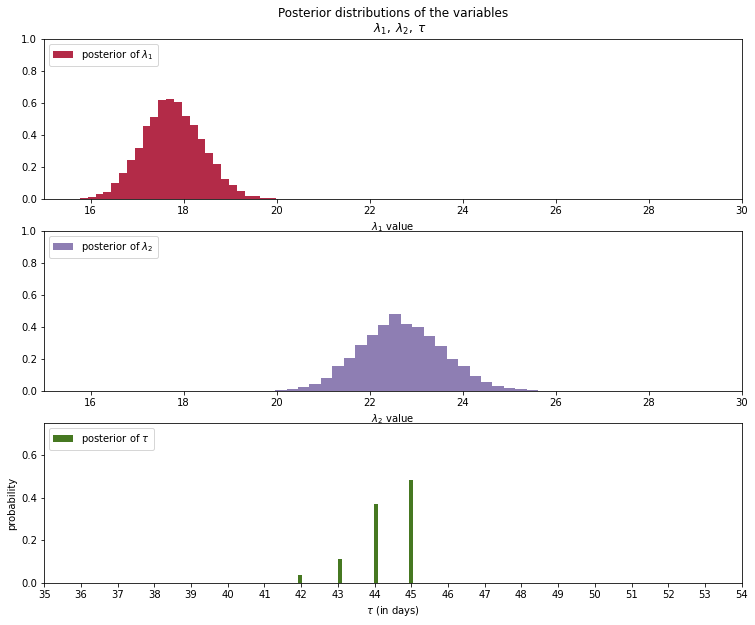

In [10]:
figsize(12.5, 10)
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", density=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");

前面说过，贝叶斯方法会返回分布。因此，我们现在有分布来描述未知数λ和 τ。我们获得了什么？我们立刻就可以看到估计中的不确定性：分布越宽，我们的后验信念应该越不确定。我们还可以看到参数的合理值是：λ1 大约是18； λ2 大约是23。这两个λ的后验分布 显然是不同的，表明用户的短信行为确实确实有可能发生了变化。

还可以有哪些其他观察？如果再次查看原始数据，这些结果看上去合理吗？

注意， λs看起来并不像指数分布，即使我们给这些变量的先验是指数分布的。实际上，后验分布并不是我们从原始模型中识别出的任何形式。但是没关系！这是采用计算观点的好处之一。如果我们改为使用数学方法进行此分析，则我们将陷入分析上难以处理（且混乱）的分布。我们对计算方法的使用能使我们对数学上的可处理性要求变得不那么至关重要。

我们的分析还返回了 τ 的后验分布，它与其他两个后验分布略有不同，因为它是一个离散的随机变量，因此它不会将概率分配到区间。我们可以看到，在第45天附近，用户的行为发生改变的可能性为50％。如果没有发生变化，或者随着时间的推移变化是逐渐的，则后验分布τ 将会更加分散，反映出来就是许多天似乎都是 τ。相比之下，在实际结果中，我们看到只有三到四天才是可能的过渡点。

Anyway，为什么我要从后验取样？

我们将在后续部分讨论这个问题，现在，以另外一个示例结束本文。

我们将使用后验样本来回答以下问题：0 ≤t≤ 70范围内，每天预期的文本数是多少 ？回想一下，泊松变量的期望值等于其参数λ。因此，问题等价于λ 在时间 t的期望值是多少？

在下面的代码中，让 i索引后验分布的样本。给定一天t，我们对  t天所有可能的 λ取平均值： 使用 $\lambda_i = \lambda_{1,i}$ ，if $t \lt \tau_i$ （也就是说，尚未发生行为更改），else 使用 $\lambda_i = \lambda_{2,i}$

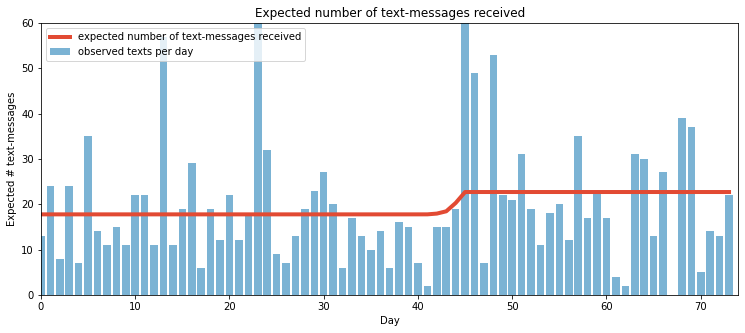

In [11]:
figsize(12.5, 5)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left");

分析表明，坚信用户的行为确实发生了变化（ 如果不是这样的话，λ1本来应该接近 λ2），这种变化是突然的，而不是渐进的（τ的后验分布峰值非常强烈）。我们可以推测是什么导致了这种情况：更便宜的短信费用，最近的天气短信订阅，或者可能是新的恋爱关系。

最后总结下，到现在为止，我们只要能够认识到我们要对我们的问题建模（$\tau , \lambda _1,\lambda _2 \rightarrow \lambda$），模型是一个不确定性的模型，也就是说模型中包含不确定性的参数（$\tau , \lambda _1,\lambda _2$都是概率性质的），我们可以对设置先验，然后结合观测，就能得到关于参数的后验了。方法的介绍后续再补充。